In [1]:
# Install YOLOv8 and KaggleHub
!pip install ultralytics kagglehub --upgrade


In [2]:
# Standard library imports
import os
import random
import shutil
from pathlib import Path

# Third-party imports
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO

In [3]:
# Download Kvasir-SEG dataset using KaggleHub
# https://www.kaggle.com/datasets/debeshjha1/kvasirseg
# Colorectal Cancer
path = kagglehub.dataset_download("debeshjha1/kvasirseg")
print("Path to dataset files:", path)

# Inspect folder structure
os.listdir(path)


Path to dataset files: C:\Users\Vaibhav\.cache\kagglehub\datasets\debeshjha1\kvasirseg\versions\3


['Kvasir-SEG', 'README.md', 'train.txt', 'val.txt']

In [4]:
# Real dataset folder
dataset_path = os.path.join(path, "Kvasir-SEG", "Kvasir-SEG")

# List all files
all_files = sorted(os.listdir(dataset_path))
all_files[:10]  # show first 10 files


['1911.07069.pdf', 'annotated_images', 'bbox', 'images', 'masks']

In [5]:
# Paths for YOLOv8 setup
base_dir = os.path.join(os.getcwd(), "Kvasir-SEG-YOLO")
os.makedirs(f"{base_dir}/images/train", exist_ok=True)
os.makedirs(f"{base_dir}/images/val", exist_ok=True)
os.makedirs(f"{base_dir}/labels/train", exist_ok=True)
os.makedirs(f"{base_dir}/labels/val", exist_ok=True)

images_path = os.path.join(dataset_path, "images")
masks_path  = os.path.join(dataset_path, "masks")


In [6]:
# Helper function to copy images and masks with proper YOLOv8 format
def copy_image_mask_yolo(name, img_dest, mask_dest):
    img_file = name + ".jpg"
    mask_file = name + ".jpg"  # original mask in masks/

    # Copy image
    shutil.copy(os.path.join(images_path, img_file), os.path.join(img_dest, img_file))

    # Read mask as grayscale
    mask = cv2.imread(os.path.join(masks_path, mask_file), cv2.IMREAD_GRAYSCALE)
    
    # Check if the mask was read successfully
    if mask is None:
        print(f"Warning: Could not read mask file {mask_file}")
        return

    # Ensure the mask is binary (0 or 255)
    _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Save the processed mask as a single-channel PNG
    cv2.imwrite(os.path.join(mask_dest, name + ".png"), mask_binary)

In [7]:
# Read train/val splits
with open(os.path.join(path, "train.txt")) as f:
    train_files = [x.strip() for x in f.readlines()]
with open(os.path.join(path, "val.txt")) as f:
    val_files = [x.strip() for x in f.readlines()]

# Clear old labels just in case
shutil.rmtree(f"{base_dir}/labels/train", ignore_errors=True)
shutil.rmtree(f"{base_dir}/labels/val", ignore_errors=True)
os.makedirs(f"{base_dir}/labels/train", exist_ok=True)
os.makedirs(f"{base_dir}/labels/val", exist_ok=True)

# Copy files
for name in train_files:
    copy_image_mask_yolo(name, f"{base_dir}/images/train", f"{base_dir}/labels/train")
for name in val_files:
    copy_image_mask_yolo(name, f"{base_dir}/images/val", f"{base_dir}/labels/val")

# Sanity check
print("Train images:", len(os.listdir(f"{base_dir}/images/train")))
print("Train labels:", len(os.listdir(f"{base_dir}/labels/train")))
print("Val images:", len(os.listdir(f"{base_dir}/images/val")))
print("Val labels:", len(os.listdir(f"{base_dir}/labels/val")))


Train images: 880
Train labels: 880
Val images: 120
Val labels: 120


In [10]:
def convert_png_to_yolo_seg(masks_dir):
    
    masks_path = Path(masks_dir)
    # Get all .png files
    mask_files = list(masks_path.glob("*.png"))
    
    if not mask_files:
        print(f"No PNG files found in {masks_dir}. Skipping.")
        return

    print(f"Converting {len(mask_files)} PNG masks in {masks_dir} to YOLO .txt format...")

    for mask_file in tqdm(mask_files):
        # Read the mask image
        mask = cv2.imread(str(mask_file))

        # Ensure it's a 2D grayscale image
        if len(mask.shape) == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        h, w = mask.shape
        segments = []

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Assuming the largest contour is the one we want
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Normalize coordinates
            normalized_contour = largest_contour.flatten().tolist()
            normalized_points = [f"{p / w if i % 2 == 0 else p / h:.6f}" for i, p in enumerate(normalized_contour)]
            
            # Create YOLO format string (class_index normalized_points...)
            # We assume a single class with index 0
            yolo_line = "0 " + " ".join(normalized_points)
            
            # Define the output .txt file path
            output_file = mask_file.with_suffix(".txt")
            
            # Write to the .txt file
            with open(output_file, 'w') as f:
                f.write(yolo_line)

# Define paths
train_labels_path = Path("C:/Users/Vaibhav/Z_Train/Kvasir-SEG-YOLO/labels/train/")
val_labels_path = Path("C:/Users/Vaibhav/Z_Train/Kvasir-SEG-YOLO/labels/val/")

# --- Run Conversion ---
convert_png_to_yolo_seg(train_labels_path)
convert_png_to_yolo_seg(val_labels_path)

print("\nConversion complete. Your labels are now in YOLO .txt format.")
print("You can now proceed to the training cell.")

Converting 880 PNG masks in C:\Users\Vaibhav\Z_Train\Kvasir-SEG-YOLO\labels\train to YOLO .txt format...


100%|██████████| 880/880 [00:20<00:00, 43.02it/s]


Converting 120 PNG masks in C:\Users\Vaibhav\Z_Train\Kvasir-SEG-YOLO\labels\val to YOLO .txt format...


100%|██████████| 120/120 [00:02<00:00, 40.41it/s]


Conversion complete. Your labels are now in YOLO .txt format.
You can now proceed to the training cell.


In [11]:
# Clear old YOLO caches
train_cache = os.path.join(base_dir, "labels/train.cache")
val_cache   = os.path.join(base_dir, "labels/val.cache")

if os.path.exists(train_cache):
    os.remove(train_cache)
if os.path.exists(val_cache):
    os.remove(val_cache)

print("Old YOLO cache cleared.")


Old YOLO cache cleared.


In [12]:
# Create dataset YAML
dataset_yaml = f"""
train: {base_dir}/images/train
val: {base_dir}/images/val

nc: 1
names: ['polyp']
"""

# Save YAML file
yaml_path = "kvasir_seg.yaml"
with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print(f"Dataset YAML created at: {yaml_path}")


Dataset YAML created at: kvasir_seg.yaml


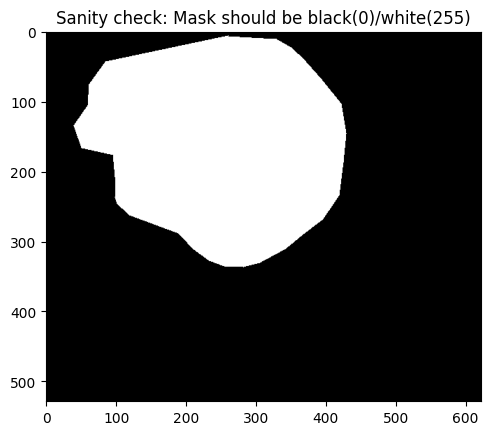

In [13]:
# sanity check of masks
# Check that masks are 0/255
mask_file = os.path.join(base_dir, "labels/train", train_files[0]+".png")
mask = Image.open(mask_file)
plt.imshow(mask, cmap='gray')
plt.title("Sanity check: Mask should be black(0)/white(255)")
plt.show()


In [14]:
# Load YOLOv8 segmentation model
model = YOLO("yolov8s-seg.pt")  # yolov8n-seg is faster but smaller

# Train the model
model.train(
    data="kvasir_seg.yaml",
    epochs=35,       
    imgsz=640,       
    batch=4,         # adjust based on GPU memory
    device=0,        # GPU
    workers=4,       # dataloader workers
    optimizer="AdamW",
    save_period=5,   # save every 5 epochs
    name="kvasir_seg_yolov8s",  # output folder name
)


Ultralytics 8.3.198  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kvasir_seg.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=kvasir_seg_yolov8s8, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspecti

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021A28B922F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

🚀 Re-running validation to confirm model performance...
Ultralytics 8.3.198  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients, 39.9 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 301.7132.5 MB/s, size: 80.9 KB)
val: Scanning C:\Users\Vaibhav\Z_Train\Kvasir-SEG-YOLO\labels\val.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 57.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.2it/s 6.5s0.5ss
                   all        120        120      0.847       0.75      0.868      0.629      0.847       0.75      0.866      0.625
Speed: 0.9ms preprocess, 13.8ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to C:\Users\Vaibhav\Z_Train\runs\segment\val3

--- Final Model Metrics ---
Mask mAP50-95: 0.6245
Mask mAP50:   

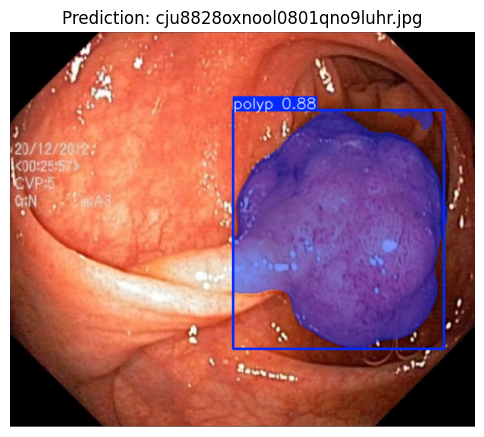

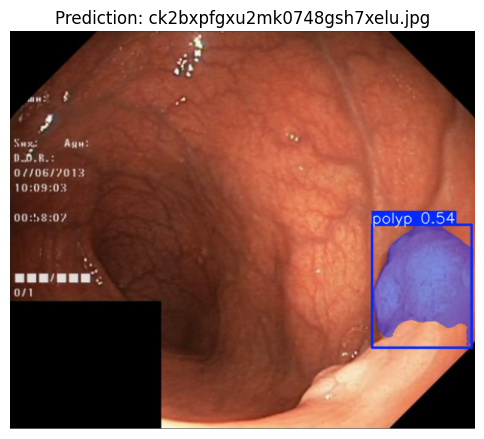

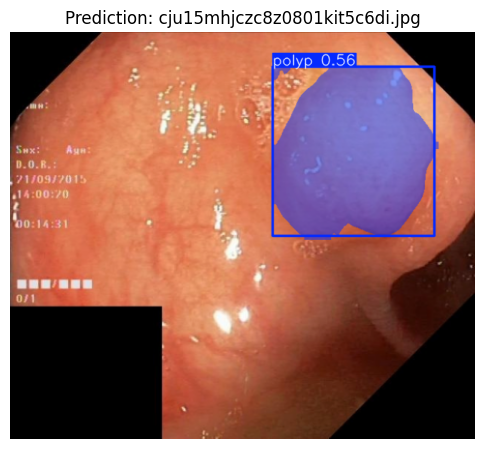

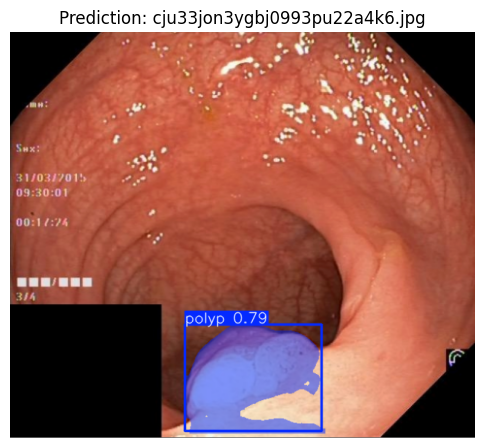

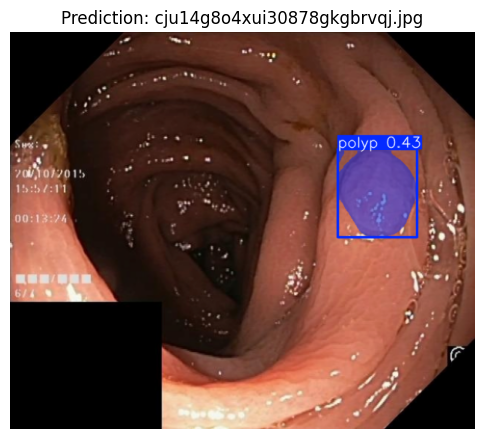

In [17]:
# --- 1. Load the Best Trained Model ---
model_path = 'C:/Users/Vaibhav/Z_Train/runs/segment/kvasir_seg_yolov8s8/weights/best.pt'
model = YOLO(model_path)

# --- 2. Re-run Evaluation on the Validation Set ---
print("🚀 Re-running validation to confirm model performance...")
metrics = model.val(plots=True, verbose=False) # Set verbose=False to hide the detailed per-class output here
print("\n--- Final Model Metrics ---")
print(f"Mask mAP50-95: {metrics.seg.map:.4f}")
print(f"Mask mAP50:    {metrics.seg.map50:.4f}")
print("---------------------------\n")


# --- 3. Visualize Predictions with Smaller Images ---
print("🖼️ Visualizing predictions on 5 random validation images...")

val_images_path = Path("C:/Users/Vaibhav/Z_Train/Kvasir-SEG-YOLO/images/val/")
val_image_files = list(val_images_path.glob("*.jpg"))

num_images_to_show = 5
if len(val_image_files) > num_images_to_show:
    sample_images = random.sample(val_image_files, num_images_to_show)
else:
    sample_images = val_image_files

for img_file in sample_images:
    results = model.predict(source=str(img_file), imgsz=640, device=0, verbose=False)
    
    pred_img_bgr = results[0].plot()
    
    pred_img_rgb = pred_img_bgr[..., ::-1]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_img_rgb)
    plt.title(f"Prediction: {img_file.name}")
    plt.axis('off')
    plt.show()

Ultralytics 8.3.198  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients, 39.9 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 320.8261.9 MB/s, size: 155.6 KB)
val: Scanning C:\Users\Vaibhav\Z_Train\Kvasir-SEG-YOLO\labels\val.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 8.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.2it/s 6.9s0.5ss
                   all        120        120      0.847       0.75      0.868      0.629      0.847       0.75      0.866      0.625
Speed: 1.7ms preprocess, 12.1ms inference, 0.0ms loss, 8.1ms postprocess per image
Results saved to C:\Users\Vaibhav\Z_Train\runs\segment\val4


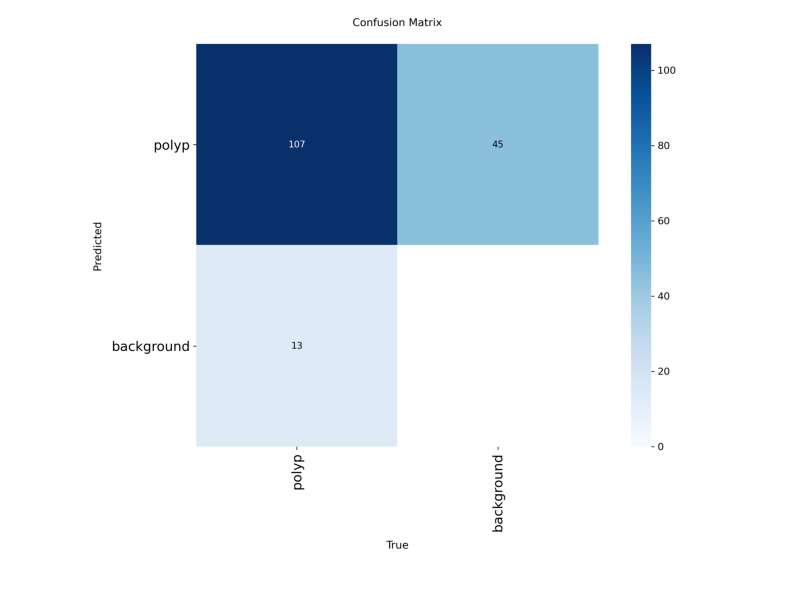

In [18]:
# Load the model and run validation to generate the confusion matrix plot
model = YOLO('C:/Users/Vaibhav/Z_Train/runs/segment/kvasir_seg_yolov8s8/weights/best.pt')
results = model.val(plots=True, verbose=False)

# Define the path and display the confusion matrix image
try:
    cm_path = Path(results.save_dir) / 'confusion_matrix.png'
    img = Image.open(cm_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print("❌ Confusion matrix image not found. Please check the validation run.")